## Interpretando um Modelo de Risco de Crédito

Neste notebook iremos construir um modelo de Machine Learning para prever o risco de default de uma pessoa. E a ideia é utilizar métodos de interpretabilidade de Machine Learning para explicar as predições que fizemos.

Utilizaremos o dataset **Give Me Some Credit** disponibilizado na plataforma de competição Kaggle.

Fonte: https://www.kaggle.com/c/GiveMeSomeCredit/

### Problema de Negócio

Os bancos desempenham um papel crucial nas economias de mercado. Eles decidem quem pode obter financiamento e em quais termos, e pode tomar ou quebrar decisões de investimento. Para que os mercados e a sociedade funcionem, os indivíduos e as empresas precisam ter acesso ao crédito.

Os algoritmos de pontuação de crédito, que calculam a probabilidade de inadimplência, são o método que os bancos usam para determinar se um empréstimo deve ou não ser concedido.

Mas e se quisermos entender **o porque os modelos realizaram essas predições**, ou ainda, saber se o modelo construído **é confiável**. Saber detalhar como um modelo funciona é relevante para **justificar eventuais políticas de negócio construídas com ele**.

### Dicionário das Variáveis

- **SeriousDlqin2yrs:** A pessoa experimentou 90 dias de inadimplência ou pior
- **RevolvingUtilizationOfUnsecuredLines:** Saldo total em cartões de crédito e linhas de crédito pessoais, exceto imóveis e nenhuma dívida parcelada, como empréstimos para automóveis, dividido pela soma dos limites de crédito
- **age:** Idade do mutuário em anos
- **NumberOfTime30-59DaysPastDueNotWorse:** Número de vezes que o mutuário esteve 30-59 dias atrasado, mas não piorou nos últimos 2 anos.
- **DebtRatio:** Pagamentos mensais de dívidas, pensão alimentícia, custo de vida dividido pela renda bruta mensal
- **MonthlyIncome:** Renda mensal
- **NumberOfOpenCreditLinesAndLoans:** Número de empréstimos em aberto (parcelado como empréstimo de carro ou hipoteca) e linhas de crédito (por exemplo, cartões de crédito)
- **NumberOfTimes90DaysLate:** Número de vezes que o mutuário está 90 dias ou mais atrasado.
- **NumberRealEstateLoansOrLines:** Número de hipotecas e empréstimos imobiliários, incluindo linhas de crédito de home equity
- **NumberOfTime60-89DaysPastDueNotWorse:** Número de vezes que o mutuário esteve 60-89 dias atrasado, mas não piorou nos últimos 2 anos.
- **NumberOfDependents:** Número de dependentes na família, excluindo eles próprios (cônjuge, filhos etc.)

### Importando Bibliotecas

In [1]:
!pip install --upgrade pandas numpy scikit-learn matplotlib seaborn xgboost pdpbox pycebox --user

  Using cached matplotlib-3.4.1-cp37-cp37m-win_amd64.whl (7.1 MB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import xgboost as xgb
import sklearn.metrics as metrics

from pdpbox import pdp
from pycebox.ice import ice, ice_plot

import warnings
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Importando Dados

In [3]:
df = pd.read_csv('cs-training.csv', sep=',')
df.shape

(150000, 12)

In [4]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
df = df.drop(columns=['Unnamed: 0'])

### Inspecionando Dados

In [6]:
print(f'O dataset possui: {df.shape[0]} linhas e {df.shape[1]} colunas')

O dataset possui: 150000 linhas e 11 colunas


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

#### Estatísticas Descritivas

In [8]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


#### Taxa de Inadimplência

In [9]:
print('Taxa de Inadimplência:', round(np.mean(df['SeriousDlqin2yrs']), 2))

Taxa de Inadimplência: 0.07


#### Cardinalidade

In [10]:
for f in df.columns:
    print(f, ' - ',df[f].value_counts().shape[0])

SeriousDlqin2yrs  -  2
RevolvingUtilizationOfUnsecuredLines  -  125728
age  -  86
NumberOfTime30-59DaysPastDueNotWorse  -  16
DebtRatio  -  114194
MonthlyIncome  -  13594
NumberOfOpenCreditLinesAndLoans  -  58
NumberOfTimes90DaysLate  -  19
NumberRealEstateLoansOrLines  -  28
NumberOfTime60-89DaysPastDueNotWorse  -  13
NumberOfDependents  -  13


#### Missings

In [11]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

#### Análise de Correlação

Inicialmente, utilizaremos a correlação de Pearson nessa análise.

In [12]:
numericas = ['SeriousDlqin2yrs','RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse',
             'DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate',
             'NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']

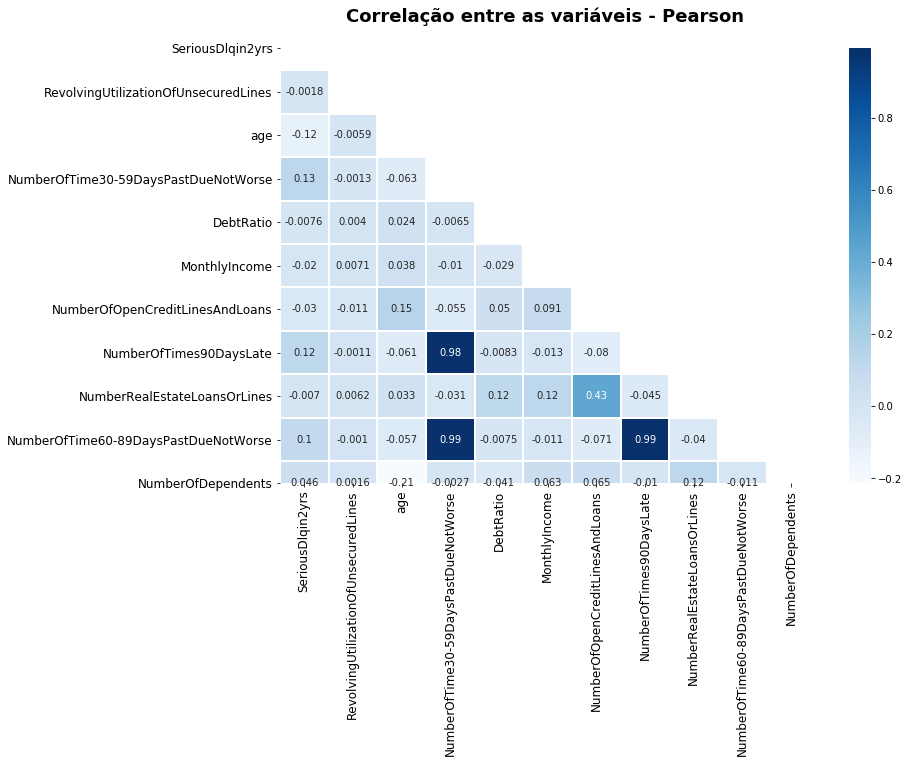

In [13]:
corr = df[numericas].corr(method='pearson')

mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12, 8))
plt.title('Correlação entre as variáveis - Pearson \n', fontsize=18, fontweight='bold')
sns.heatmap(corr, cmap='Blues', annot=True, linewidths=1, linecolor='white', mask=mask)
plt.box(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Agora, utilizaremos a correlação de Spearman.

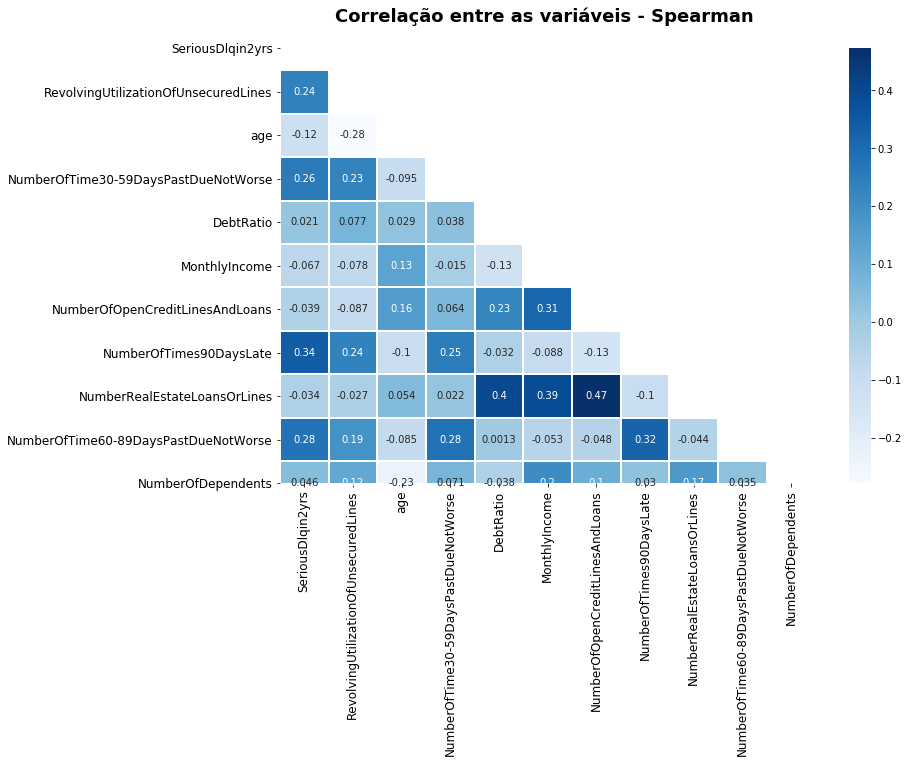

In [14]:
corr = df[numericas].corr(method='spearman')

mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12, 8))
plt.title('Correlação entre as variáveis - Spearman \n', fontsize=18, fontweight='bold')
sns.heatmap(corr, cmap='Blues', annot=True, linewidths=1, linecolor='white', mask=mask)
plt.box(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [15]:
# Dropando colunas altamente correlacionadas
df = df.drop(columns=['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'])

### Dataprep

#### Separar conjuntos de treino e teste

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['SeriousDlqin2yrs'], axis=1),
                                                    df['SeriousDlqin2yrs'],
                                                    test_size=0.20,
                                                    random_state=123)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120000, 8), (30000, 8), (120000,), (30000,))

#### Imputar Missings

In [18]:
X_train['MonthlyIncome'] = X_train['MonthlyIncome'].fillna(0)
X_test['MonthlyIncome'] = X_test['MonthlyIncome'].fillna(0)

X_train['NumberOfDependents'] = X_train['NumberOfDependents'].fillna(0)
X_test['NumberOfDependents'] = X_test['NumberOfDependents'].fillna(0)

### Treinamento dos Modelos

#### Treinar Modelo XGBoost

Como queremos prever um evento de incidência muito pequena, nós otimizaremos a àrea da curva PRC, visando acertar o maior número possível de pessoas que entraram em default.

In [19]:
model1 = xgb.XGBClassifier(objective = 'binary:logistic',
                           max_depth = 6,
                           eval_metric = 'aucpr',
                           eta = 0.025,
                           gamma = 0.65,
                           random_state = 123456)

model1.fit(X_train, y_train)

# Treino
y_pred_xgb1_train = model1.predict(X_train)
y_score_xgb1_train = model1.predict_proba(X_train)[:,1]

# Teste
y_pred_xgb1_test = model1.predict(X_test)
y_score_xgb1_test = model1.predict_proba(X_test)[:,1]

#### Avaliando o resultado do modelo

In [20]:
def avaliar_metricas_modelo(y, y_hat, y_prob):
    
    cm = metrics.confusion_matrix(y, y_hat)
    accuracy = metrics.accuracy_score(y, y_hat)
    f1 = metrics.f1_score(y, y_hat)
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)
    auc_roc = metrics.auc(fpr, tpr)
    prec, rec, _ = metrics.precision_recall_curve(y, y_prob)
    auc_prc = metrics.auc(rec, prec)
    gini = ((2*auc_roc) - 1)
    
    print('Acurácia: ', round(accuracy, 2))
    print('F1: ', round(f1, 2))
    print('AUC ROC: ', round(auc_roc, 2))
    print('AUC PRC: ', round(auc_prc, 2))
    print('Gini: ', round(gini, 2))
    
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='d')
    plt.xlabel('Predito', fontsize=14)
    plt.ylabel('Atual', fontsize=14)
    plt.title('Matriz de Confusão', fontsize=18)
    
    plt.show();

Acurácia:  0.94
F1:  0.14
AUC ROC:  0.84
AUC PRC:  0.36
Gini:  0.69


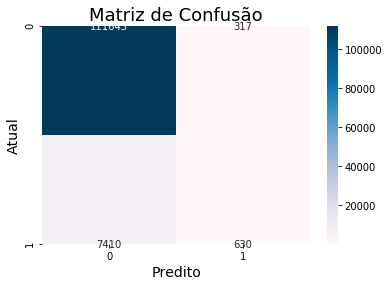

In [21]:
avaliar_metricas_modelo(y_train, y_pred_xgb1_train, y_score_xgb1_train)

Acurácia:  0.94
F1:  0.12
AUC ROC:  0.84
AUC PRC:  0.32
Gini:  0.67


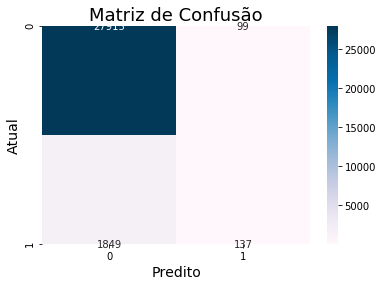

In [22]:
avaliar_metricas_modelo(y_test, y_pred_xgb1_test, y_score_xgb1_test)

### Avaliando e Interpretando os Modelos

#### Distribuição de Probabilidade

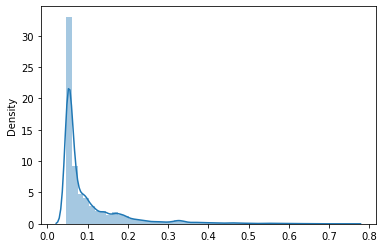

In [23]:
sns.distplot(y_score_xgb1_train)

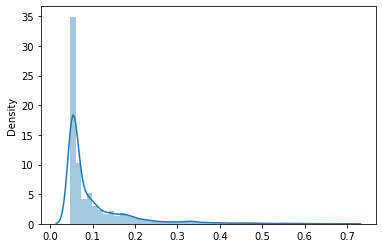

In [24]:
sns.distplot(y_score_xgb1_test)

#### Importância das Variáveis - Weight, Gain e Cover

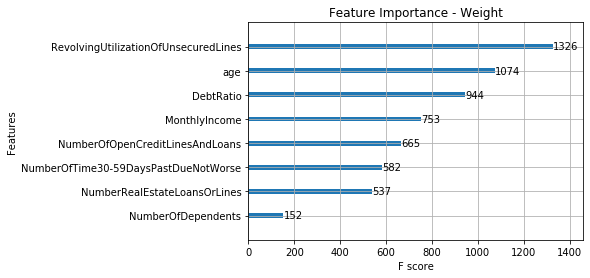

In [25]:
xgb.plot_importance(model1, importance_type='weight', title='Feature Importance - Weight')

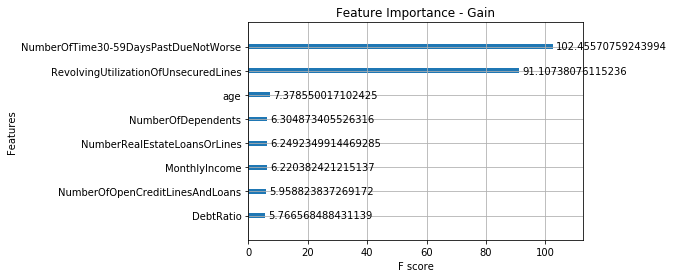

In [26]:
xgb.plot_importance(model1, importance_type='gain', title='Feature Importance - Gain')

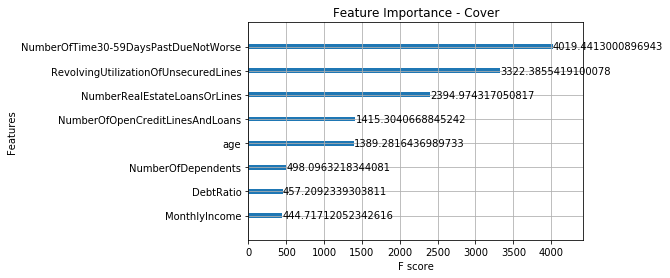

In [27]:
xgb.plot_importance(model1, importance_type='cover', title='Feature Importance - Cover')

#### Importância das Variáveis - Permutation Importance

- Método que mede o aumento no erro de predição uma vez que os valores das features foram embaralhados
- É agnóstico ao modelo, pode ser utilziado em qualquer técnica de Machine Learning

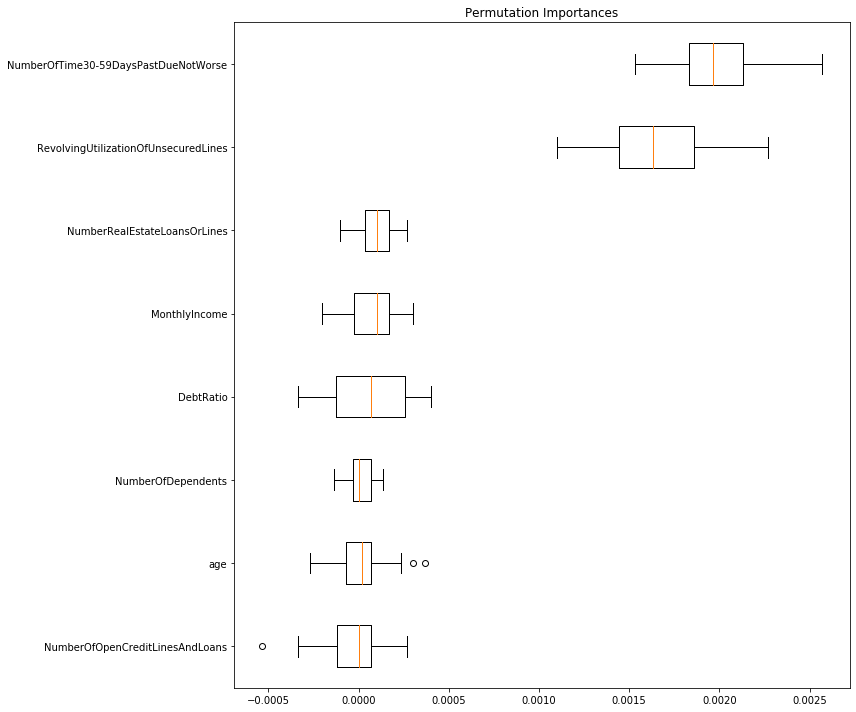

In [28]:
result = permutation_importance(model1, X_test, y_test, n_repeats=50, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12, 10))
ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X_test.columns[perm_sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

#### Partial Dependence Plots (PDPs)

- Método que transmite o efeito marginal de uma feature na predição em todos os valores possíveis para aquela feature
- É um **método global de interpretação** que possibilita visualizar o impacto da feature e a natureza da relação com o target (linear, exponencial, monotônica, etc)
- Podemos extender essa análise para duas features, quando quisermos ver a interação entre elas

In [29]:
feature_names = ['NumberOfTime30-59DaysPastDueNotWorse',
                 'RevolvingUtilizationOfUnsecuredLines',
                 'DebtRatio',
                 'NumberOfOpenCreditLinesAndLoans',
                 'age']

##### Isolate PDPs

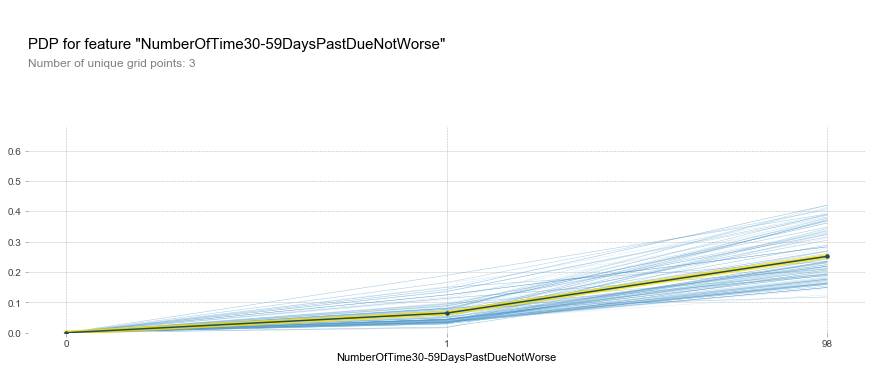

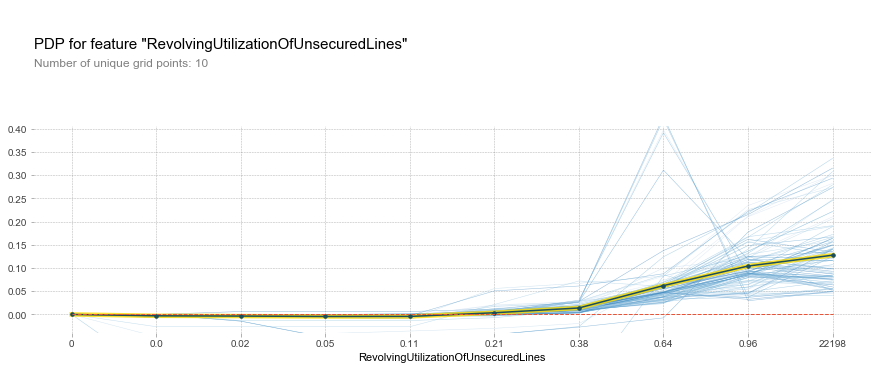

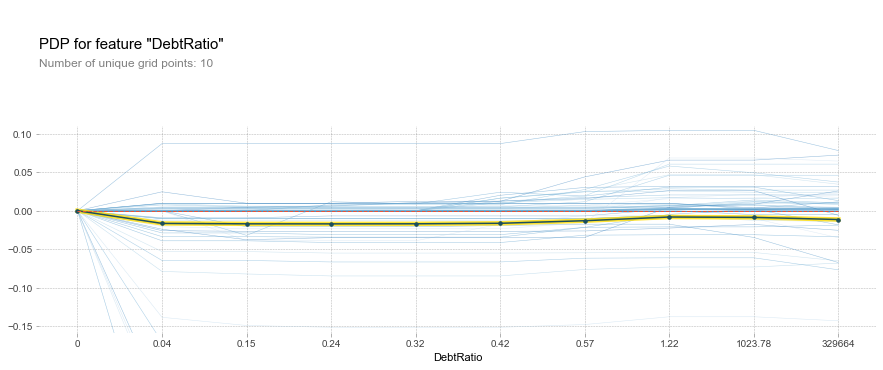

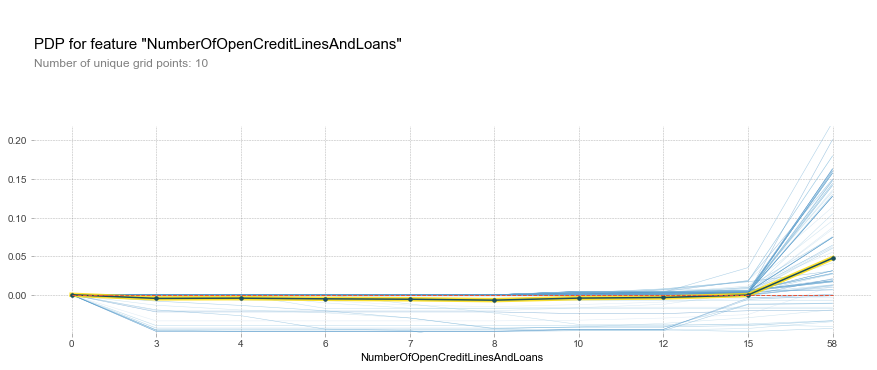

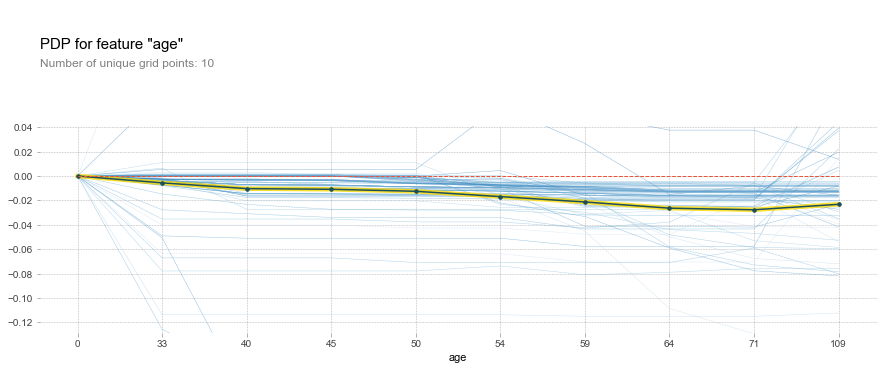

In [30]:
for i in range(len(feature_names)):
    pdp_feat_df = pdp.pdp_isolate(model=model1,
                                  dataset=X_train,
                                  model_features=X_train.columns,
                                  feature=feature_names[i])
    fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_feat_df,
                             center=True,
                             x_quantile=True,
                             plot_lines=True,
                             frac_to_plot=100,
                             figsize=(15,6),
                             feature_name=feature_names[i])

##### Interaction PDPs

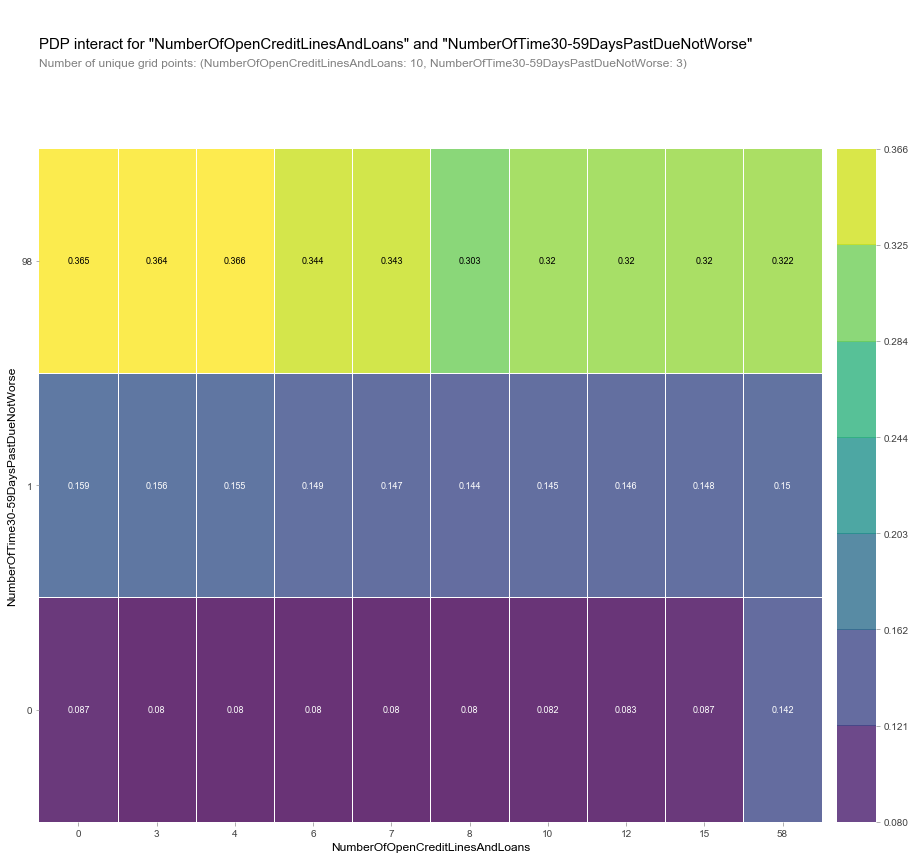

In [31]:
pdp_interact_df_01 = pdp.pdp_interact(model=model1,
                                      dataset=X_train,
                                      model_features=X_train.columns,
                                      features=['NumberOfOpenCreditLinesAndLoans','NumberOfTime30-59DaysPastDueNotWorse'],
                                      n_jobs=-1)

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_interact_df_01,
                                  plot_type='grid',
                                  x_quantile=True,
                                  figsize=(15,15),
                                  feature_names=['NumberOfOpenCreditLinesAndLoans','NumberOfTime30-59DaysPastDueNotWorse'])

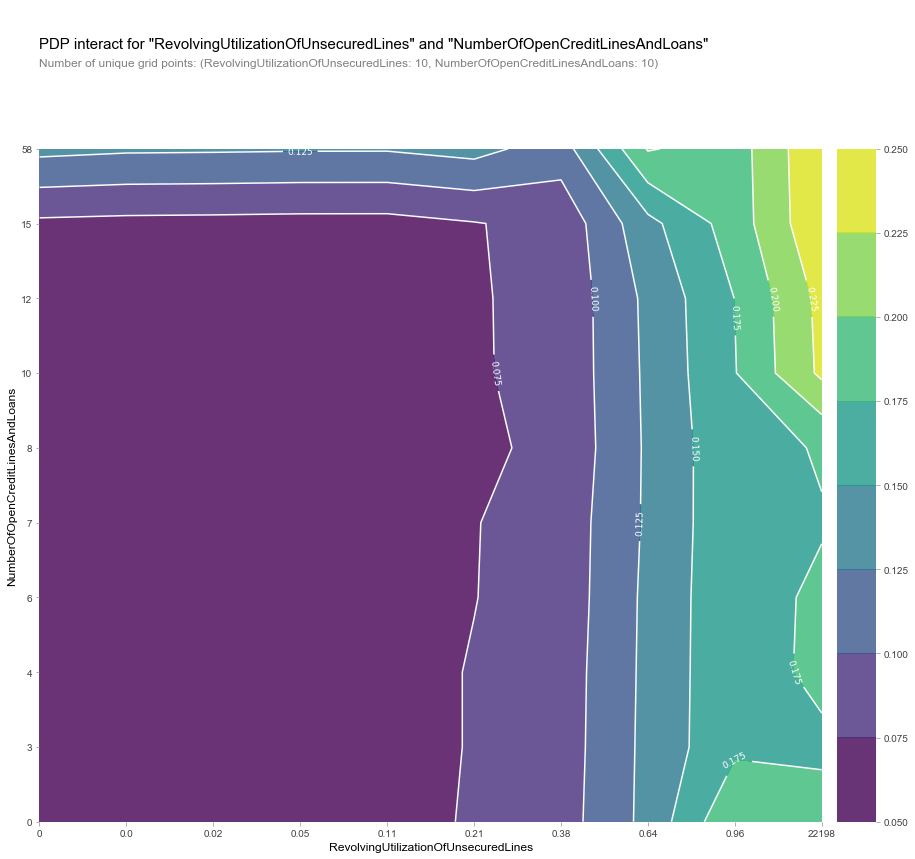

In [32]:
pdp_interact_df_02 = pdp.pdp_interact(model=model1,
                                      dataset=X_train,
                                      model_features=X_train.columns,
                                      features=['RevolvingUtilizationOfUnsecuredLines','NumberOfOpenCreditLinesAndLoans'],
                                      n_jobs=-1)

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_interact_df_02,
                                  plot_type='contour',
                                  x_quantile=True,
                                  ncols=2,
                                  figsize=(15,15),
                                  feature_names=['RevolvingUtilizationOfUnsecuredLines','NumberOfOpenCreditLinesAndLoans'])

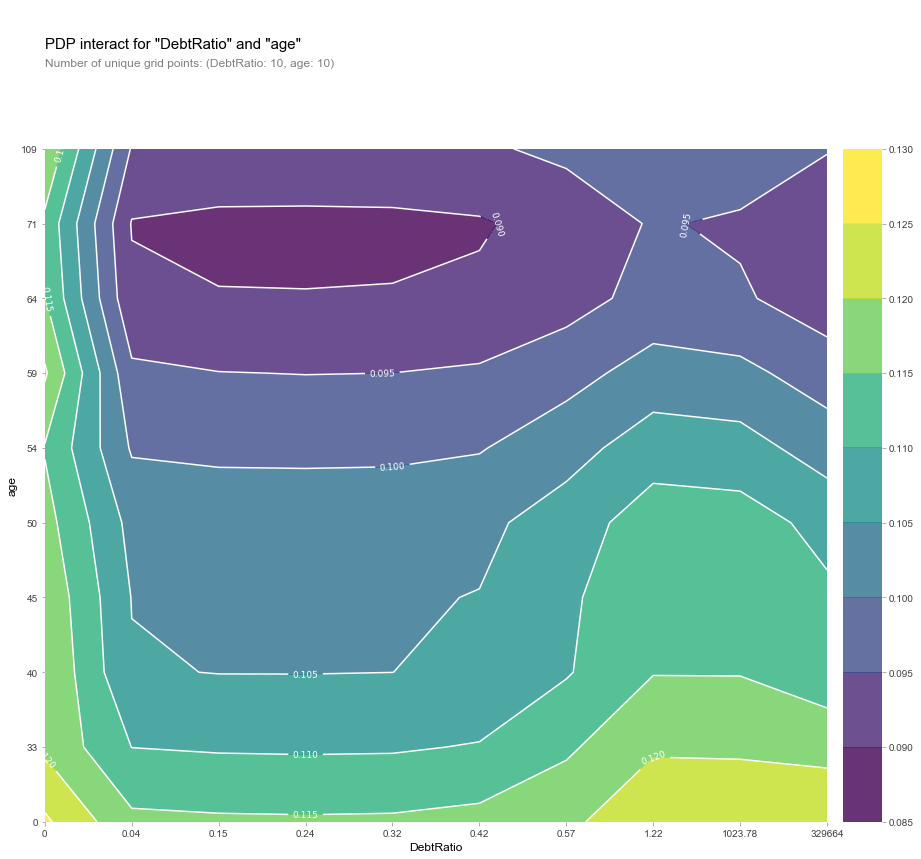

In [33]:
pdp_interact_df_02 = pdp.pdp_interact(model=model1,
                                      dataset=X_train,
                                      model_features=X_train.columns,
                                      features=['DebtRatio','age'],
                                      n_jobs=-1)

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_interact_df_02,
                                  plot_type='contour',
                                  x_quantile=True,
                                  ncols=2,
                                  figsize=(15,15),
                                  feature_names=['DebtRatio','age'])

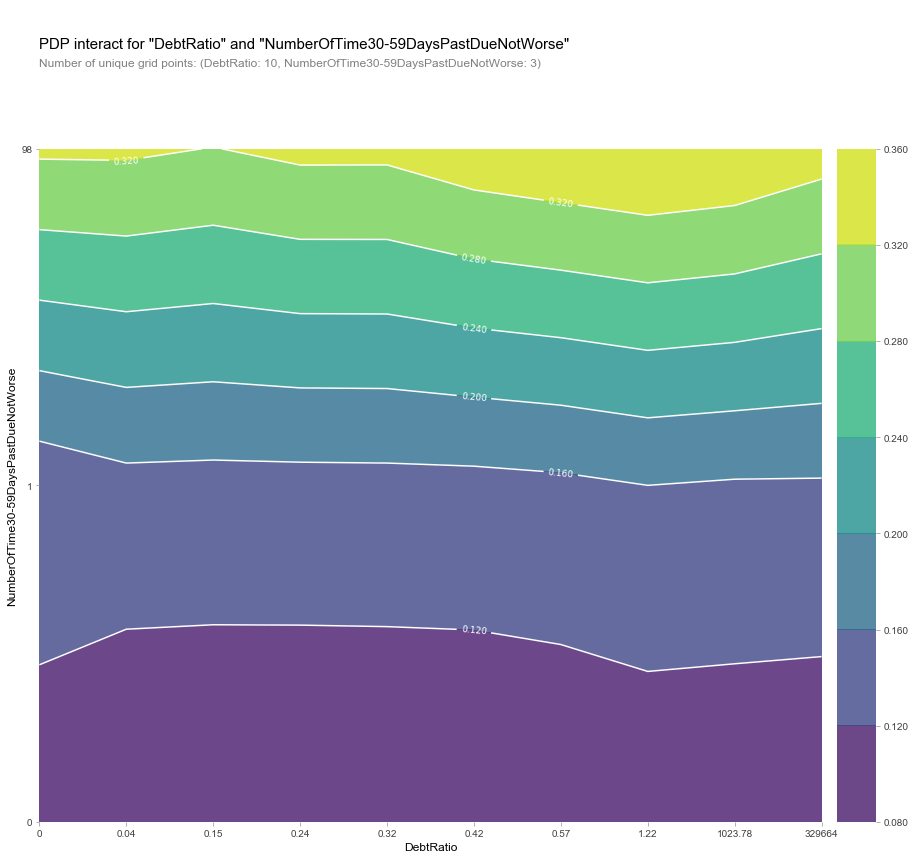

In [34]:
pdp_interact_df_02 = pdp.pdp_interact(model=model1,
                                      dataset=X_train,
                                      model_features=X_train.columns,
                                      features=['DebtRatio','NumberOfTime30-59DaysPastDueNotWorse'],
                                      n_jobs=-1)

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_interact_df_02,
                                  plot_type='contour',
                                  x_quantile=True,
                                  ncols=2,
                                  figsize=(15,15),
                                  feature_names=['DebtRatio','NumberOfTime30-59DaysPastDueNotWorse'])

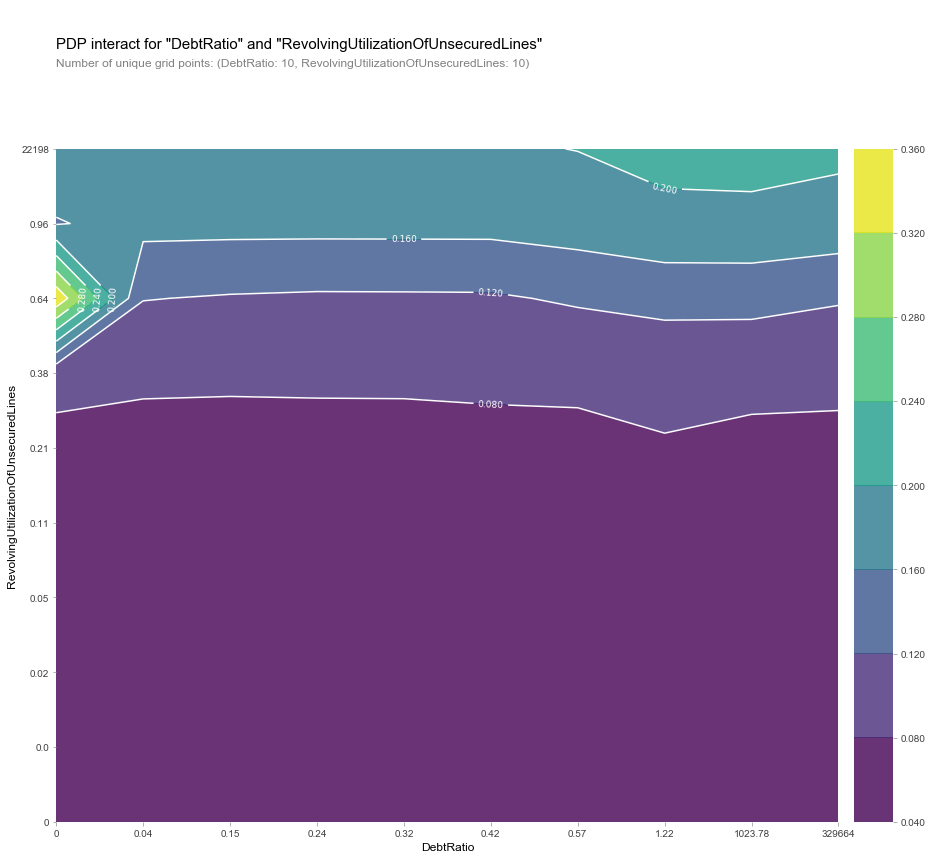

In [35]:
pdp_interact_df_02 = pdp.pdp_interact(model=model1,
                                      dataset=X_train,
                                      model_features=X_train.columns,
                                      features=['DebtRatio','RevolvingUtilizationOfUnsecuredLines'],
                                      n_jobs=-1)

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_interact_df_02,
                                  plot_type='contour',
                                  x_quantile=True,
                                  ncols=2,
                                  figsize=(15,15),
                                  feature_names=['DebtRatio','RevolvingUtilizationOfUnsecuredLines'])

#### Individual Conditional Expectation (ICE)

- Diferentemente do PDP, este método captura o papel da variância nas relações entre feature e target
- É um **método local de interpretação** que possibilita visualizar as dependências entre feature e target ao nível de instância
- O PDP é a média do resultado do ICE

In [36]:
X_test_samp = X_test.sample(frac=0.12, replace=True, random_state=112).reset_index(drop=True)
X_test_samp.shape

(3600, 8)

In [37]:
# Vamos selecionar um cliente aleatório

X_test_samp[X_test_samp['NumberOfTime30-59DaysPastDueNotWorse']>5].sample(n=1, random_state=666)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents
337,0.99347,51,11,0.534183,3685.0,17,0,0.0


In [38]:
# Original Copyright (c) 2015 Austin Rochford and contributors.
# This code is a derivative work of code distributed under the  MIT License (MIT)
# https://github.com/AustinRochford/PyCEbox

def my_ice_plot(ice_data, 
                INS_df, # Instance of interest
                INS_xy, # feature value and prediction for the instance
                frac_to_plot=1.,
                plot_points=False, point_kwargs=None,
                x_quantile=False, 
                centered=False, centered_quantile=0.,
                color_by=None, cmap=None, ax=None, 
                plot_pdp=False,
                plot_ins=False,
                pdp_kwargs=None, 
                INS_df_kwargs=None, 
                INS_xy_kwargs=None,
                **kwargs):

    if not ice_data.index.is_monotonic_increasing:
        ice_data = ice_data.sort_index()

    if centered:
        quantiles = _get_quantiles(ice_data.index)
        centered_quantile_iloc = np.abs(quantiles - centered_quantile).argmin()
        ice_data = ice_data - ice_data.iloc[centered_quantile_iloc]

    if frac_to_plot < 1.:
        n_cols = ice_data.shape[1]
        icols = np.random.choice(n_cols, size=frac_to_plot * n_cols, replace=False)
        plot_ice_data = ice_data.iloc[:, icols]
    else:
        plot_ice_data = ice_data


    if x_quantile:
        x = _get_quantiles(ice_data.index)
    else:
        x = ice_data.index

    if plot_points:
        point_x_ilocs = _get_point_x_ilocs(plot_ice_data.index, plot_ice_data.columns)
        point_x = x[point_x_ilocs]
        point_y = plot_ice_data.values[point_x_ilocs, np.arange(point_x_ilocs.size)]

    if ax is None:
        _, ax = plt.subplots()


    if color_by is not None:
        if isinstance(color_by, six.string_types):
            colors_raw = plot_ice_data.columns.get_level_values(color_by).values
        elif hasattr(color_by, '__call__'):
            col_df = pd.DataFrame(list(plot_ice_data.columns.values), columns=plot_ice_data.columns.names)
            colors_raw = color_by(col_df)
        else:
            raise ValueError('color_by must be a string or function')

        norm = colors.Normalize(colors_raw.min(), colors_raw.max())
        m = cm.ScalarMappable(norm=norm, cmap=cmap)

        for color_raw, (_, ice_curve) in zip(colors_raw, plot_ice_data.iteritems()):
            c = m.to_rgba(color_raw)
            ax.plot(x, ice_curve, c=c, zorder=0, **kwargs)
    else:
        ax.plot(x, plot_ice_data, zorder=0, **kwargs)

    if plot_points:
        ax.scatter(point_x, point_y, zorder=30, **(point_kwargs or {}))

    if plot_pdp:
        pdp_kwargs = pdp_kwargs or {}
        pdp_data = pdp(ice_data)
        ax.plot(x, pdp_data, **pdp_kwargs)

# Plot Instance
    if plot_ins:
        ax.plot(x, INS_df, **INS_df_kwargs)
        ax.plot(INS_xy[0], INS_xy[1], zorder=10, **INS_xy_kwargs)
    return ax 


def pdp(ice_data):
    Hilight = ice_data.mean(axis=1)
    return Hilight


# Function Definitions

def get_ins(feature_ice_df, odf, Feature, INS):
    instance_df = move_col(odf, Feature)  
    INS_tuple = tuple(instance_df.iloc[INS, :])
    #  print('INS_tuple: ', INS_tuple)
    INS_line = feature_ice_df.loc[:, INS_tuple]
    #  print('INS_line:', INS_line)
    INS_df = pd.DataFrame(INS_line)
    #  print(INS_df)
    return INS_df

def move_col(df, Col):
    df1 = pd.DataFrame(df[Col])
    df2 = df.drop(Col, axis=1)
    df3 = pd.concat([df1, df2], axis=1)
    return df3

def Ins_Feat_Pred(INS, Feat, odf, INS_df):
    FeatN = odf.columns.get_loc(Feat)
    Row_idx = odf.iloc[INS, FeatN]
    idf = move_col(odf, Feat)
    Col_idx = tuple(idf.iloc[INS, :])
    Pred = INS_df.loc[Row_idx, Col_idx]
    return tuple([Row_idx, Pred])

def predict_prob(test_df):
    return model1.predict_proba(test_df)[:,1]

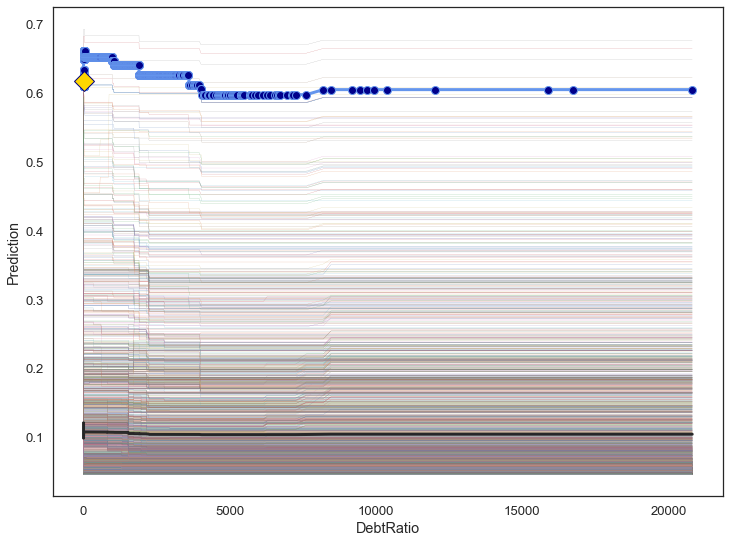

In [39]:
# Gerando ICE Plot - 'DebtRatio'

sns.set(style="white",  font_scale=1.2, rc={"figure.figsize":(12,9)})

ice_df = ice(data=X_test_samp,
             column='DebtRatio',
             predict=predict_prob)

# get Instance df and xy
INS_df = get_ins(ice_df, X_test_samp, 'DebtRatio', 337)
INS_xy = Ins_Feat_Pred(337, 'DebtRatio', X_test_samp, INS_df)

my_ice_plot(ice_df, 
            INS_df, 
            INS_xy,
            linewidth=0.15,
            plot_pdp=True,
            plot_ins=True,
            pdp_kwargs={'c': 'k', 'linewidth': 3, 'alpha':0.9, 'zorder':5000},           
            INS_df_kwargs={'c': 'cornflowerblue', 'linewidth': 3, 'marker':'o', 'markersize':8, 'markerfacecolor':'darkblue'},
            INS_xy_kwargs={'marker':'D', 'markersize':14, 'markerfacecolor':'gold', 'markeredgecolor':'navy'}
            )

plt.ylabel('Prediction')
plt.xlabel('DebtRatio')
plt.show()

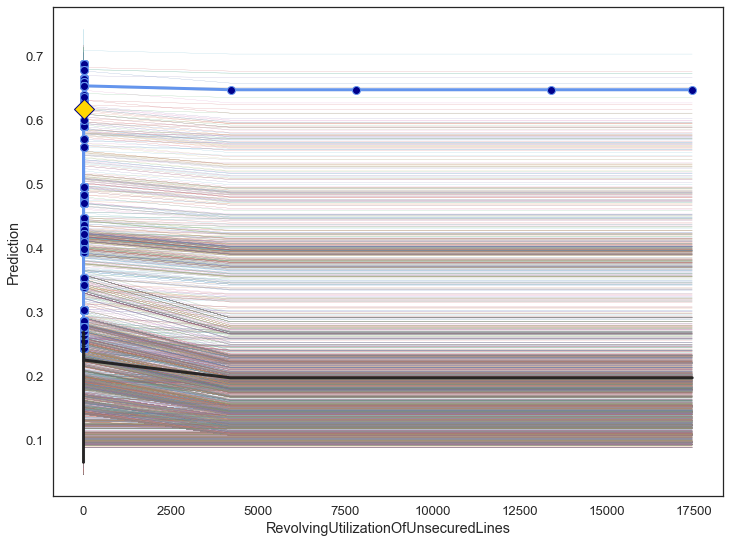

In [40]:
# Gerando ICE Plot - 'RevolvingUtilizationOfUnsecuredLines'

sns.set(style="white",  font_scale=1.2, rc={"figure.figsize":(12,9)})

ice_df = ice(data=X_test_samp,
             column='RevolvingUtilizationOfUnsecuredLines',
             predict=predict_prob)

# get Instance df and xy
INS_df = get_ins(ice_df, X_test_samp, 'RevolvingUtilizationOfUnsecuredLines', 337)
INS_xy = Ins_Feat_Pred(337, 'RevolvingUtilizationOfUnsecuredLines', X_test_samp, INS_df)

my_ice_plot(ice_df, 
            INS_df, 
            INS_xy,
            linewidth=0.15,
            plot_pdp=True,
            plot_ins=True,
            pdp_kwargs={'c': 'k', 'linewidth': 3, 'alpha':0.9, 'zorder':5000},           
            INS_df_kwargs={'c': 'cornflowerblue', 'linewidth': 3, 'marker':'o', 'markersize':8, 'markerfacecolor':'darkblue'},
            INS_xy_kwargs={'marker':'D', 'markersize':14, 'markerfacecolor':'gold', 'markeredgecolor':'navy'}
            )

plt.ylabel('Prediction')
plt.xlabel('RevolvingUtilizationOfUnsecuredLines')
plt.show()

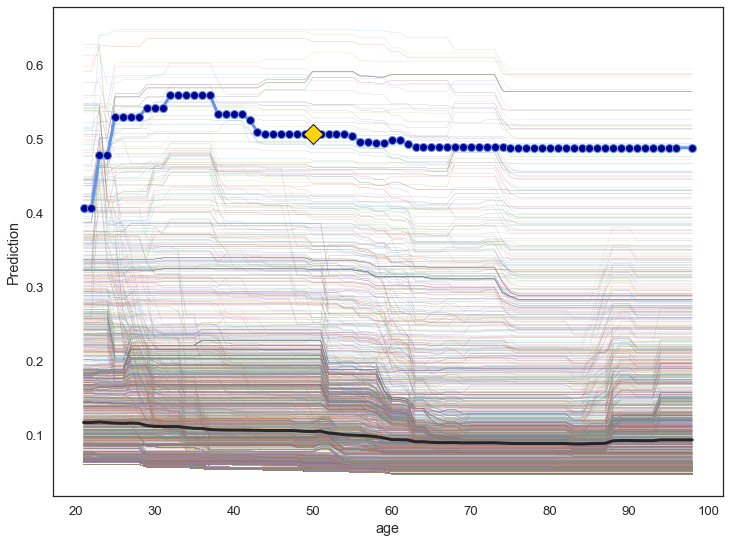

In [41]:
# Gerando ICE Plot - 'age'

sns.set(style="white",  font_scale=1.2, rc={"figure.figsize":(12,9)})

ice_df = ice(data=X_test_samp,
             column='age',
             predict=predict_prob)

# get Instance df and xy
INS_df = get_ins(ice_df, X_test_samp, 'age', 1531)
INS_xy = Ins_Feat_Pred(1531, 'age', X_test_samp, INS_df)

my_ice_plot(ice_df, 
            INS_df, 
            INS_xy,
            linewidth=0.15,
            plot_pdp=True,
            plot_ins=True,
            pdp_kwargs={'c': 'k', 'linewidth': 3, 'alpha':0.9, 'zorder':5000},           
            INS_df_kwargs={'c': 'cornflowerblue', 'linewidth': 3, 'marker':'o', 'markersize':8, 'markerfacecolor':'darkblue'},
            INS_xy_kwargs={'marker':'D', 'markersize':14, 'markerfacecolor':'gold', 'markeredgecolor':'navy'}
            )

plt.ylabel('Prediction')
plt.xlabel('age')
plt.show()

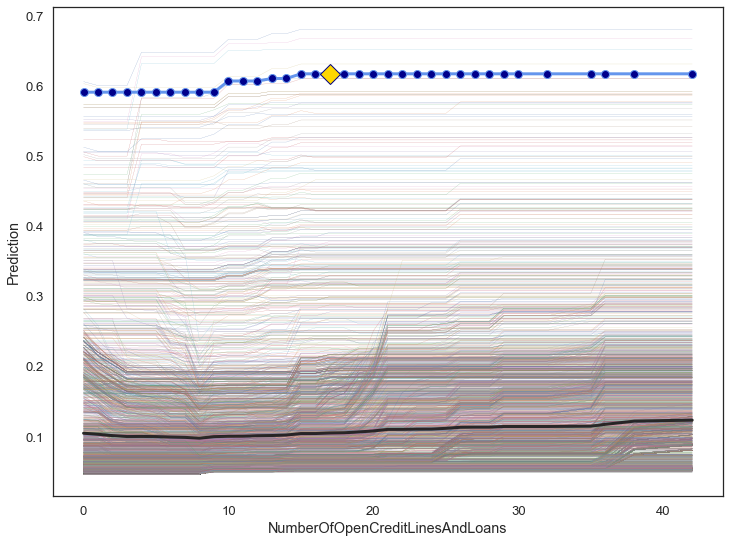

In [42]:
# Gerando ICE Plot - 'NumberOfOpenCreditLinesAndLoans'

sns.set(style="white",  font_scale=1.2, rc={"figure.figsize":(12,9)})

ice_df = ice(data=X_test_samp,
             column='NumberOfOpenCreditLinesAndLoans',
             predict=predict_prob)

# get Instance df and xy
INS_df = get_ins(ice_df, X_test_samp, 'NumberOfOpenCreditLinesAndLoans', 337)
INS_xy = Ins_Feat_Pred(337, 'NumberOfOpenCreditLinesAndLoans', X_test_samp, INS_df)

my_ice_plot(ice_df, 
            INS_df, 
            INS_xy,
            linewidth=0.15,
            plot_pdp=True,
            plot_ins=True,
            pdp_kwargs={'c': 'k', 'linewidth': 3, 'alpha':0.9, 'zorder':5000},           
            INS_df_kwargs={'c': 'cornflowerblue', 'linewidth': 3, 'marker':'o', 'markersize':8, 'markerfacecolor':'darkblue'},
            INS_xy_kwargs={'marker':'D', 'markersize':14, 'markerfacecolor':'gold', 'markeredgecolor':'navy'}
            )

plt.ylabel('Prediction')
plt.xlabel('NumberOfOpenCreditLinesAndLoans')
plt.show()

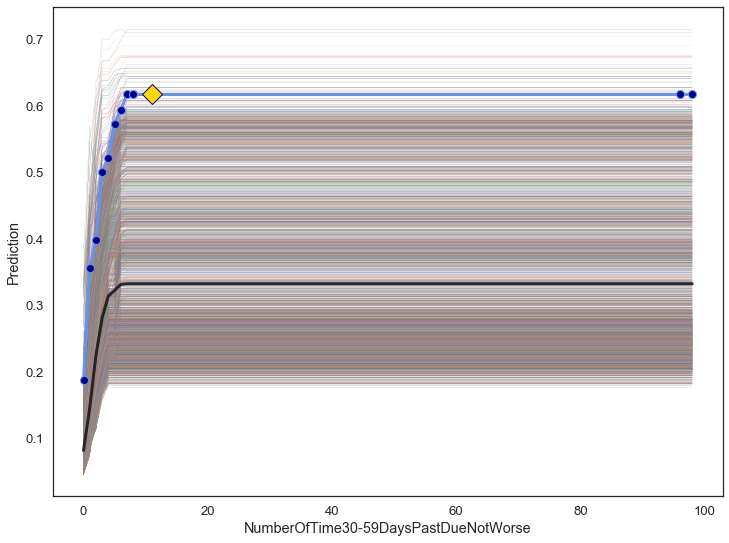

In [43]:
# Gerando ICE Plot - 'NumberOfTime30-59DaysPastDueNotWorse'

sns.set(style="white",  font_scale=1.2, rc={"figure.figsize":(12,9)})

ice_df = ice(data=X_test_samp,
             column='NumberOfTime30-59DaysPastDueNotWorse',
             predict=predict_prob)

# get Instance df and xy
INS_df = get_ins(ice_df, X_test_samp, 'NumberOfTime30-59DaysPastDueNotWorse', 337)
INS_xy = Ins_Feat_Pred(337, 'NumberOfTime30-59DaysPastDueNotWorse', X_test_samp, INS_df)

my_ice_plot(ice_df, 
            INS_df, 
            INS_xy,
            linewidth=0.15,
            plot_pdp=True,
            plot_ins=True,
            pdp_kwargs={'c': 'k', 'linewidth': 3, 'alpha':0.9, 'zorder':5000},           
            INS_df_kwargs={'c': 'cornflowerblue', 'linewidth': 3, 'marker':'o', 'markersize':8, 'markerfacecolor':'darkblue'},
            INS_xy_kwargs={'marker':'D', 'markersize':14, 'markerfacecolor':'gold', 'markeredgecolor':'navy'}
            )

plt.ylabel('Prediction')
plt.xlabel('NumberOfTime30-59DaysPastDueNotWorse')
plt.show()